In [42]:
# import library 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.float_format', '{:20,.2f}'.format)
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import LearningRateScheduler

<Figure size 1152x288 with 0 Axes>

In [2]:
# read data 
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

# check data

In [3]:
train.head(3)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.0,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4


In [4]:
# IDENTITY_COLUMNS (신원을 파악할 수 있는 변수)
IDENTITY_COLUMNS = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish','muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# AUX_COLUMNS (additional toxicity subtype attributes) 
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

# missinv values

In [5]:
tmp = train.isnull().sum(axis=0) / len(train)
tmp[tmp > 0]

asian                                  0.775536
atheist                                0.775536
bisexual                               0.775536
black                                  0.775536
buddhist                               0.775536
christian                              0.775536
female                                 0.775536
heterosexual                           0.775536
hindu                                  0.775536
homosexual_gay_or_lesbian              0.775536
intellectual_or_learning_disability    0.775536
jewish                                 0.775536
latino                                 0.775536
male                                   0.775536
muslim                                 0.775536
other_disability                       0.775536
other_gender                           0.775536
other_race_or_ethnicity                0.775536
other_religion                         0.775536
other_sexual_orientation               0.775536
physical_disability                    0

In [6]:
identities = [
    'male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
    'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
    'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
    'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness','other_disability'
]

tmp = train.loc[:, ['target'] + identities ].dropna()
toxic_df = tmp[tmp['target'] >= .5][identities]
non_toxic_df = tmp[tmp['target'] < .5][identities]
print('toxic_df',len(toxic_df)/len(tmp))
print('non_toxic_df',len(non_toxic_df)/len(tmp))

toxic_df 0.11363019277762694
non_toxic_df 0.886369807222373


# check the comments

In [7]:
print(train[train.target==1].iloc[1,2])

Dear world:
Just a reminder that none of these folks actually live in Oregon.  Please remember that when you decide to paint our state as a bunch of wackos! 

Sincerely,
Oregon


In [8]:
print(train[train.severe_toxicity==1].iloc[0,2])

Awesome! Lets cut the head off hate! Lets stab it and burn its house down! lets march together and beat hate with rocks and clubs and run out out of town! Hooray for us for showing hate we will not tolerate it and will kill or beat down any that oppose or stance against hate. 

Yeah, that sounds like the good guys. Why is it so hard for people to admit that using violence to achieve a goal is not acceptable in a civil society?


In [9]:
print(train[train.obscene==1].iloc[1,2])

So where is Silent Bill Walker's voice on this issue?  You would think a leader would say: " Kids, cut the crap and go to your rooms, in the Atwood."  But no word from Silent Bill.  The next we hear from Walker will be his crying about how we need to give him PFD and tax money to buy a TajMahawker for his kids.


In [10]:
print(train[train.identity_attack==1].iloc[1,2])

The Braves, Siletz tribe Feather, tomahawk, etc. are cultural, just like the fighting Irish, and David Douglas Scotts. White mascots and white cultures are not being banned. Native Americans are singled out. It is Native American culture to have mascots, and we have had them for thousands of years before whitey showed up. As for redskins being racially offensive to us red skin injuns, Oklahoma where my Chickasaw family is from was named by an Indian using Indian words that mean RED PEOPLE. Ever notice how liberals explain how WHITE conservatives are out of touch with the BLACK community, but if I say I am a red skin Chickasaw who thinks liberals are morons, I become a racist bigot for saying red...hence why I think most liberals are morons and especially when it comes to their PC racist stereotyping of us Indians.


In [11]:
print(train[train.insult==1].iloc[1,2])

Dear world:
Just a reminder that none of these folks actually live in Oregon.  Please remember that when you decide to paint our state as a bunch of wackos! 

Sincerely,
Oregon


In [12]:
print(train[train.threat==1].iloc[1,2])

WHY do they allow them to plea down? I was abused, he should hang by the neck until dead.


# count sub-target

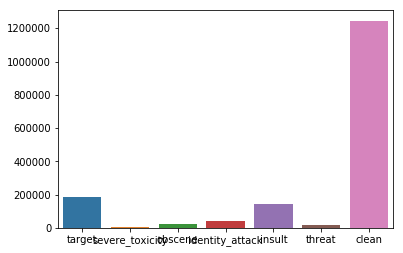

In [13]:
# tox label counts
tox_labels = train[AUX_COLUMNS].copy()
rowsums = tox_labels.sum(axis=1)
train['clean']=(rowsums==0)
tox_labels['clean']=train['clean'].copy()
x = tox_labels.sum().copy()
sns.barplot(x.index, x.values)

# correlation matrix

                   target  severe_toxicity   obscene  identity_attack  \
target           1.000000         0.393425  0.493058         0.450017   
severe_toxicity  0.393425         1.000000  0.340570         0.256599   
obscene          0.493058         0.340570  1.000000         0.124823   
identity_attack  0.450017         0.256599  0.124823         1.000000   
insult           0.928207         0.324847  0.427176         0.310748   
threat           0.287761         0.277789  0.090928         0.146662   

                   insult    threat  
target           0.928207  0.287761  
severe_toxicity  0.324847  0.277789  
obscene          0.427176  0.090928  
identity_attack  0.310748  0.146662  
insult           1.000000  0.108575  
threat           0.108575  1.000000  


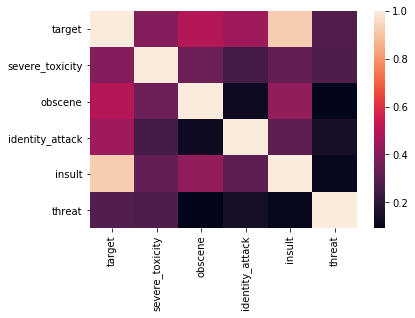

In [14]:
# corr matrix
corr = train[AUX_COLUMNS].corr()
print(corr)
sns.heatmap(corr) 

# extra features 

In [15]:
train['total_length'] = train['comment_text'].apply(len)
train['capitals'] = train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
train['num_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))
train['num_question_marks'] = train['comment_text'].apply(lambda comment: comment.count('?'))
train['num_punctuation'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train['num_symbols'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
train['num_words'] = train['comment_text'].apply(lambda comment: len(comment.split()))
train['num_unique_words'] = train['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
train['words_vs_unique'] = train['num_unique_words'] / train['num_words']
train['num_smilies'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

In [53]:
train['all_capitals_YN'] = train.apply(lambda row: float(row['capitals'])==float(row['total_length']),axis=1)

In [59]:
features = [
'total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 
'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique', 'num_smilies', 'num_symbols',
'all_capitals_YN'
]    
tmp = train[['target']+features].copy()
tmp = tmp.apply(lambda x:np.where(x>=0.5,1,0))
tmp.groupby(features)['target'].agg([np.mean,np.sum,np.size]).T

total_length                             1                       \
capitals                                 0                        
caps_vs_length                           0                        
num_exclamation_marks                    0                        
num_question_marks                       0                        
num_punctuation                          0                        
num_words                                1                        
num_unique_words                         1                        
words_vs_unique                          0                    1   
num_smilies                              0                    0   
num_symbols                              0                    0   
all_capitals_YN                          0                    0   
mean                                  0.06                 0.12   
sum                                   2.00               947.00   
size                                 33.00             7,888.00   

total_length                                                     \
capitals                                                          
caps_vs_length                                                    
num_exclamation_marks                                             
num_question_marks                                                
num_punctuation                                               1   
num_words                                                     1   
num_unique_words                                              1   
words_vs_unique                                               0   
num_smilies                                                   0   
num_symbols                              1                    0   
all_capitals_YN                          0                    0   
mean                                  0.04                 0.14   
sum                                   8.00                 3.00   
size                                214.00                22.00   

total_length                                                     \
capitals                                                          
caps_vs_length                                                    
num_exclamation_marks                                             
num_question_marks                                                
num_punctuation                                                   
num_words                                                         
num_unique_words                                                  
words_vs_unique                                                   
num_smilies                                                   1   
num_symbols                              1                    0   
all_capitals_YN                          0                    0   
mean                                  0.00                 0.00   
sum                                   0.00                 0.00   
size                                  1.00                 1.00   

total_length                                                     \
capitals                                                          
caps_vs_length                                                    
num_exclamation_marks                                             
num_question_marks                                                
num_punctuation                                                   
num_words                                                         
num_unique_words                                                  
words_vs_unique                          1                        
num_smilies                              0                        
num_symbols                              0                    1   
all_capitals_YN                          0                    0   
mean                                  0.13                 0.11   
sum                               2,693.00               102.00   
size                             20,753.00  

In [61]:
pd.crosstab(tmp.target,tmp.all_capitals_YN)

all_capitals_YN,0,1
target,,
0,1660080,460
1,144313,21
